In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import torch
from transformers import pipeline

In [19]:
stock_file = '../data/nvidia_stock.csv'

df = pd.read_csv(stock_file, parse_dates=['Date'], dayfirst=True)
df = df[df['Date'] >= '2025-01-01']
df.set_index('Date', inplace = True)
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2025-01-02,138.309998,138.880005,134.630005,136.000000,198247200
2025-01-03,144.470001,144.899994,139.729996,140.009995,229322500
2025-01-06,149.429993,152.160004,147.820007,148.589996,265377400
2025-01-07,140.139999,153.130005,140.009995,153.029999,351782200
2025-01-08,140.110001,143.949997,137.559998,142.580002,227349900


In [20]:
api_key = 'd3625e265719408da7ffaf7cd03ef924'
#query = 'NVIDIA'
query = 'NVIDIA stock'

url = f"https://newsapi.org/v2/everything?q={query}&language=en&sortBy=publsihedAt&apiKey={api_key}"
response = requests.get(url).json()
articles = response.get('articles', [])

In [21]:
news_list = []
for article in articles:
    if 'publishedAt' in article and 'title' in article:
        news_list.append({
            'date': article['publishedAt'][:10],  # Extract only YYYY-MM-DD
            'title': article.get('title', ''),
            'description': article.get('description', '')
        })

news_df = pd.DataFrame(news_list)
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')
news_df.dropna(subset=['date'], inplace=True)
news_df.head()

,date,title,description
0,2025-01-23,How to buy a NVIDIA RTX 50 series GPU,"Following a two-year wait, NVIDIA’s highly-ant..."
1,2025-02-10,Here’s How One OEM Is Fighting Against Nvidia ...,The Nvidia RTX 5090 and 5080 are near-sold out...
2,2025-01-29,Nvidia Warns It Will Likely Run Out of RTX 509...,Some gamers are already camping out during one...
3,2025-01-30,RTX 5090 Vigilantes Attempt to Fool Scalper Bo...,As Nvidia RTX 5090 GPU is in such hot demand m...
4,2025-01-30,Nvidia stock has crossed a red line that point...,Nvidia crossed below its 200 day moving averag...


In [22]:
device = 0 if torch.cuda.is_available() else -1
sentiment_pipeline = pipeline('sentiment-analysis', model = 'nlptown/bert-base-multilingual-uncased-sentiment', device=device)

news_df['title'] = news_df['title'].fillna('')

texts = news_df['title'].tolist()
results = sentiment_pipeline(texts, truncation=True, max_length=512)

def map_sentiment(label):
    return int(label[0]) - 3

news_df['sentiment'] = [map_sentiment(res['label']) if text.strip() else 0 for text, res in zip(texts, results)]
news_df

Device set to use cuda:0


,date,title,description,sentiment
0,2025-01-23,How to buy a NVIDIA RTX 50 series GPU,"Following a two-year wait, NVIDIA’s highly-ant...",2
1,2025-02-10,Here’s How One OEM Is Fighting Against Nvidia ...,The Nvidia RTX 5090 and 5080 are near-sold out...,2
2,2025-01-29,Nvidia Warns It Will Likely Run Out of RTX 509...,Some gamers are already camping out during one...,-2
3,2025-01-30,RTX 5090 Vigilantes Attempt to Fool Scalper Bo...,As Nvidia RTX 5090 GPU is in such hot demand m...,-2
4,2025-01-30,Nvidia stock has crossed a red line that point...,Nvidia crossed below its 200 day moving averag...,-2
...,...,...,...,...
95,2025-01-27,Team Ninja's Rise Of The Ronin simply cannot r...,It's been a veritable Koei Tecmo offensive on ...,-2
96,2025-02-01,DeepSeek or DeepFake? Our vultures circle Chin...,If this keeps Silicon Valley on its toes and h...,2
97,2025-01-28,Nvidia and other tech stocks are rebounding a ...,Nvidia (NVDA) stock saw a slight turnaround Tu...,-2
98,2025-01-31,"DeepSeek sinks stocks, Big Tech earnings, and ...",Chinese artificial intelligence startup DeepSe...,2


In [23]:
daily_sentiment = news_df.groupby('date')['sentiment'].mean()

In [24]:
df['sentiment'] = daily_sentiment.reindex(df.index, fill_value=0)
df.head()

,Close,High,Low,Open,Volume,sentiment
Date,,,,,,
2025-01-02,138.309998,138.880005,134.630005,136.000000,198247200,0.0
2025-01-03,144.470001,144.899994,139.729996,140.009995,229322500,0.0
2025-01-06,149.429993,152.160004,147.820007,148.589996,265377400,0.0
2025-01-07,140.139999,153.130005,140.009995,153.029999,351782200,0.0
2025-01-08,140.110001,143.949997,137.559998,142.580002,227349900,0.0


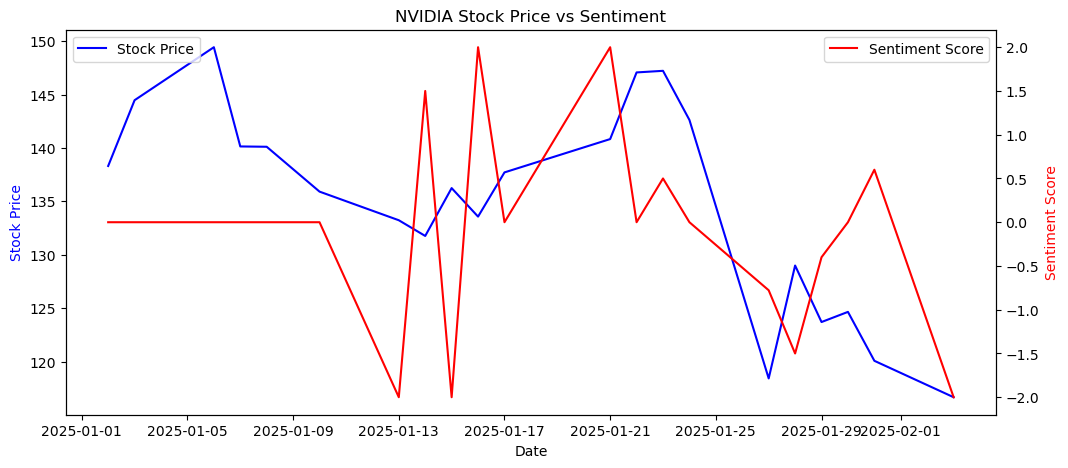

In [25]:
fig, ax1 = plt.subplots(figsize=(12,5))
ax2 = ax1.twinx()

ax1.plot(df.index, df['Close'], color='blue', label='Stock Price')
ax2.plot(df.index, df['sentiment'], color='red', label='Sentiment Score')

ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price', color='blue')
ax2.set_ylabel('Sentiment Score', color='red')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('NVIDIA Stock Price vs Sentiment')
plt.show()